In [346]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.4.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf

import pickle

#Mount Google Drive to save models
from google.colab import drive
drive.mount('/content/drive')

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,498 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,425 kB]
Fetched 4,180 kB in 2s (1,718 kB/s)
Rea

In [347]:
#Function to plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [348]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("fatema").getOrCreate()

url = 'https://raw.githubusercontent.com/FatemaGirnary/Project_4/main/Resources/heart.csv'
from pyspark import SparkFiles
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("heart.csv"), header=True)
df.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|      0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|      1|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|      0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|      0|      Up|           0|
| 39|  M|          NAP|      120|        339|        0| 

**Visualisation of raw data**

In [ ]:
#convert to pandas dataframe
p_df = df.toPandas()
p_df.head(10)

# Inspect the data
print(p_df.info())
print(p_df.describe())



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert all object columns to numeric
numeric_p_df = numeric_p_df.apply(pd.to_numeric, errors='coerce')

# Plot histograms for all columns
for column in numeric_p_df.columns:
    plt.figure(figsize=(8, 6))
    
    if pd.api.types.is_numeric_dtype(numeric_p_df[column]):  # Numeric column
        numeric_p_df[column].hist(bins=15, color='skyblue', edgecolor='black')
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
    
    else:  # Categorical column
        numeric_p_df[column].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
    
    plt.show()


**Preparing data for models**

In [350]:
# Get number of columns
num_cols = len(df.columns)

# Get number of rows
num_rows = df.count()

print(f"Number of columns: {num_cols}\nNumber of rows: {num_rows}")

Number of columns: 12
Number of rows: 918


In [351]:
from pyspark.sql.functions import count, col

# Group by all columns and count occurrences
duplicate_counts = df.groupBy(df.columns).count()

# Filter for rows with count > 1 to find duplicates
duplicates = duplicate_counts.filter(col("count") > 1)

# Count the number of duplicate rows
duplicate_count = duplicates.count()

print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [352]:

# Drop rows with any null values
df = df.dropna()

# Count the number of rows after dropping null values
row_count_after_drop = df.count()

print(f"Number of rows after dropping null values: {row_count_after_drop}")


Number of rows after dropping null values: 918


In [353]:
df.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|      0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|      1|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|      0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|      0|      Up|           0|
| 39|  M|          NAP|      120|        339|        0| 

In [354]:
p_df = df.toPandas()
p_df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0,Up,0


In [355]:
# Determine the number of unique values in each column.
unique_counts = p_df.nunique()
# Display the number of unique values for each column
print(unique_counts)

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64


In [356]:
# Convert categorical data to numeric with `pd.get_dummies`
numeric_p_df = pd.get_dummies(p_df, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])
numeric_p_df

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0,0,False,True,False,...,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1,1,True,False,False,...,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0,0,False,True,False,...,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,...,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0,0,False,True,False,...,True,False,False,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1,False,True,False,...,False,True,False,True,False,True,False,False,True,False
914,68,144,193,1,141,3.4,1,False,True,True,...,False,False,False,True,False,True,False,False,True,False
915,57,130,131,0,115,1.2,1,False,True,True,...,False,False,False,True,False,False,True,False,True,False
916,57,130,236,0,174,0,1,True,False,False,...,False,False,True,False,False,True,False,False,True,False


In [357]:
# Split our preprocessed data into our features and target arrays
target = numeric_p_df['HeartDisease']
features = numeric_p_df.drop(columns=['HeartDisease'])
X = features.values  # Features array
y = target.values    # Target array
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)

number_input_features = X_train.shape[1]
print(f"Number of input features: {number_input_features}")

features

Number of input features: 20


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0,False,True,False,True,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1,True,False,False,False,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0,False,True,False,True,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,True,False,True,False,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0,False,True,False,False,True,False,False,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,False,True,False,False,False,True,False,True,False,True,False,False,True,False
914,68,144,193,1,141,3.4,False,True,True,False,False,False,False,True,False,True,False,False,True,False
915,57,130,131,0,115,1.2,False,True,True,False,False,False,False,True,False,False,True,False,True,False
916,57,130,236,0,174,0,True,False,False,True,False,False,True,False,False,True,False,False,True,False


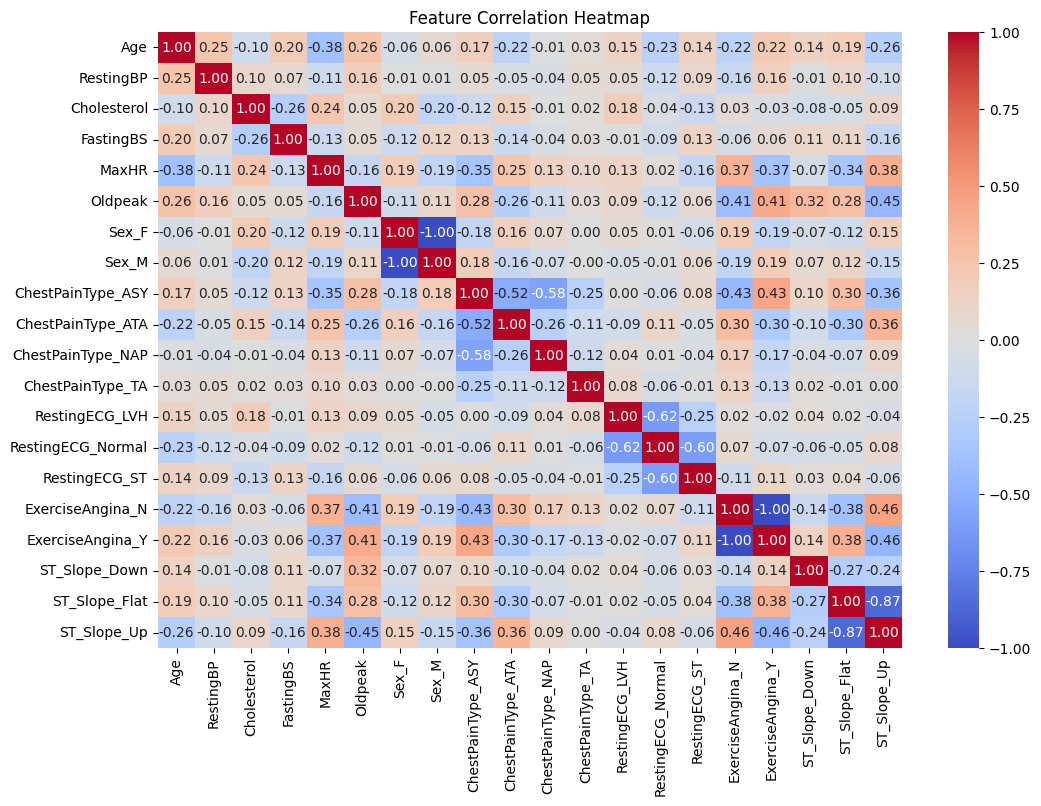

In [358]:
#Visualizing correlations between features to help understand relationships in the data.
plt.figure(figsize=(12, 8))
sns.heatmap(features.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [359]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Create a Logistic Regression Model with the Original Data

###  Step 1: Fit a logistic regression model by using the training data (`X_train` and `y_train`).

In [360]:
# Import the LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
classifier = LogisticRegression(solver='liblinear', random_state=1, max_iter=200)
classifier

# Fit the model using training data
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=1, solver='liblinear')

### Step 2: Save the predictions on the testing data labels by using the testing feature data (`X_test`) and the fitted model.

In [361]:
# Make a prediction using the testing data
predictions = classifier.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test})

,Prediction,Actual
0,1,1
1,0,0
2,1,1
3,1,1
4,0,0
...,...,...
225,1,1
226,1,1
227,0,0
228,1,1


### Step 3: Evaluate the model’s performance by doing the following:

* Generate a confusion matrix.

* Print the classification report.

In [362]:
# Generate a confusion matrix for the logistic regression model
from sklearn.metrics import confusion_matrix

print("Confusion Matrix")
confusion_matrix(y_test, predictions)

Confusion Matrix


array([[ 84,  13],
       [ 11, 122]])

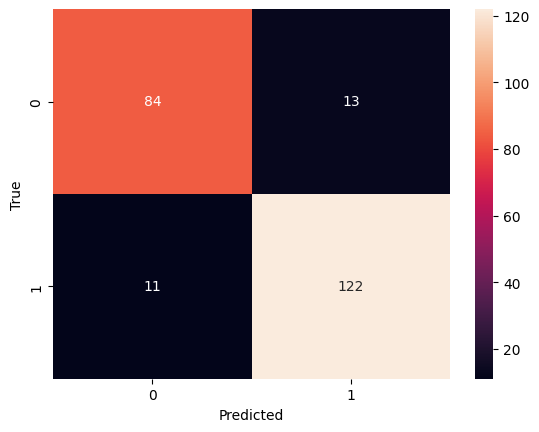

In [363]:
#Plot Confusion Matrix for the logistic regression model
plot_confusion_matrix(y_test, predictions)

In [364]:
# Print the classification report for the logistic regression model
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87        97
           1       0.90      0.92      0.91       133

    accuracy                           0.90       230
   macro avg       0.89      0.89      0.89       230
weighted avg       0.90      0.90      0.90       230



In [365]:
# Store overall metric (average) for logistic regression model accuracy to compare models at the end
report = classification_report(y_test, predictions, output_dict=True)

lrm_accuracy = report['accuracy']
lrm_macro_avg_f1 = report['macro avg']['f1-score']
lrm_weighted_avg_f1 = report['weighted avg']['f1-score']

print("\nOverall Accuracy: {:.2f}".format(lrm_accuracy))
print("Macro Avg F1-Score: {:.2f}".format(lrm_macro_avg_f1))
print("Weighted Avg F1-Score: {:.2f}".format(lrm_weighted_avg_f1))


Overall Accuracy: 0.90
Macro Avg F1-Score: 0.89
Weighted Avg F1-Score: 0.90


In [366]:
# Save the Logistic Regression model
filename = '/content/drive/My Drive/Models/logistic_regression_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

In [367]:
#Used to Test the loaded model only and compare with Streamlit app

loaded_model = pickle.load(open(filename, 'rb'))

input_data = pd.DataFrame([[38, 110, 289, 0, 105, 1.5, False, True, True, False, False,
                                False, False, True, False, False, True, True,
                                False, False]],
                              columns=['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY',
                                       'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST',
                                       'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up'])

prediction = loaded_model.predict(input_data.values)

print(prediction[0])

if prediction[0] == 0:
    print("The patient does not have a heart disease.")
else:
    print("The patient has a heart disease.")

1
The patient has a heart disease.


**Question:** How well does the logistic regression model predict both the `0` (healthy heart) and `1` (diseased heart) labels?

**Answer:** The logistic regression model performs very well for the 'healthy heart' (0) with very good precision and high recall. The model also performs very well for the 'diseased heart'(1) with strong precision and recall. The high accuracy of 90% indicates that the model handles the data very well; however, there is a slight imbalance in performance between the 'healthy heart' and 'diseased heart'. The model is slightly less accurate in predicting healthy heart.

### **Using other machine learning models**

## Fitting the Decision Tree Model

In [368]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=1)

In [369]:
# Fit the Decision Tree model to the training data
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

## Making Predictions Using the Decision Tree Model

In [370]:
# Make predictions on the test data using Decision Tree
y_pred = dt_model.predict(X_test)

## Model Evaluation of the Decision Tree Model

In [371]:
# Generate a confusion matrix for the Decision Tree model
print("Confusion Matrix")
confusion_matrix(y_test, predictions)

Confusion Matrix


array([[ 84,  13],
       [ 11, 122]])

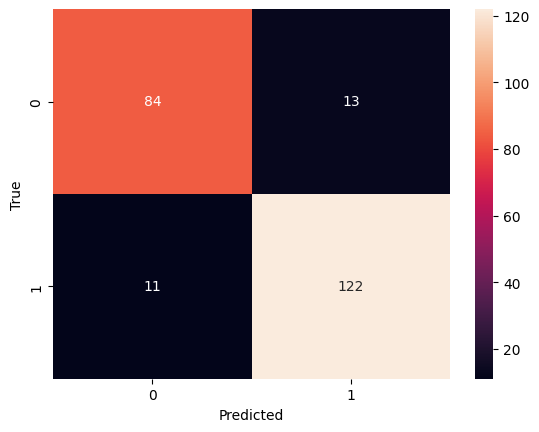

In [372]:
#Plot Confusion Matrix for the Decision Tree Model
plot_confusion_matrix(y_test, predictions)

In [373]:
# Print the classification report for the Decision Tree Model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.77      0.74        97
           1       0.82      0.76      0.79       133

    accuracy                           0.77       230
   macro avg       0.76      0.77      0.76       230
weighted avg       0.77      0.77      0.77       230



In [374]:
# Store overall metric (average) for accuracy for the Decision Tree model to compare models at the end
report = classification_report(y_test, y_pred, output_dict=True)

tm_accuracy = report['accuracy']
tm_macro_avg_f1 = report['macro avg']['f1-score']
tm_weighted_avg_f1 = report['weighted avg']['f1-score']

print("\nOverall Accuracy: {:.2f}".format(tm_accuracy))
print("Macro Avg F1-Score: {:.2f}".format(tm_macro_avg_f1))
print("Weighted Avg F1-Score: {:.2f}".format(tm_weighted_avg_f1))


Overall Accuracy: 0.77
Macro Avg F1-Score: 0.76
Weighted Avg F1-Score: 0.77


## Fitting the Random Forest Model

In [375]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=1)

In [376]:
# Fitting the Random Forest model
rf_model = rf_model.fit(X_train, y_train)

## Making Predictions Using the Random Forest Model

In [377]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test)

## Model Evaluation of the Random Forest model

> Add blockquote



In [378]:
# Generate a confusion matrix for the Random Forest model
print("Confusion Matrix")
confusion_matrix(y_test, predictions)

Confusion Matrix


array([[ 83,  14],
       [ 11, 122]])

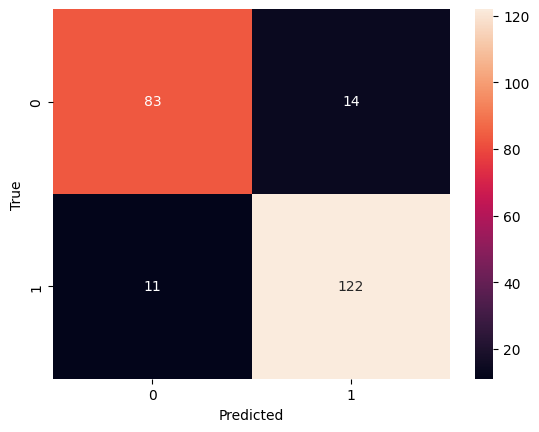

In [379]:
#Plot Confusion Matrix for the Random Forest model
plot_confusion_matrix(y_test, predictions)

In [380]:
# Print the classification report for the Random Forest model
print("Classification Report")
print(classification_report(y_test, predictions))


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        97
           1       0.90      0.92      0.91       133

    accuracy                           0.89       230
   macro avg       0.89      0.89      0.89       230
weighted avg       0.89      0.89      0.89       230



In [381]:
# Store overall metric (average) for the Random Forest model accuracy to compare models at the end
report = classification_report(y_test, predictions, output_dict=True)

rf_accuracy = report['accuracy']
rf_macro_avg_f1 = report['macro avg']['f1-score']
rf_weighted_avg_f1 = report['weighted avg']['f1-score']

print("\nOverall Accuracy: {:.2f}".format(rf_accuracy))
print("Macro Avg F1-Score: {:.2f}".format(rf_macro_avg_f1))
print("Weighted Avg F1-Score: {:.2f}".format(rf_weighted_avg_f1))


Overall Accuracy: 0.89
Macro Avg F1-Score: 0.89
Weighted Avg F1-Score: 0.89


## Random Forest model Feature Importance

In [382]:
# Random Forests in sklearn will automatically calculate feature importance
feature_names = ["Age", "Sex ", "ChestPainType", "RestingBP", "Cholesterol", "FastingBS", "RestingECG", "MaxHR", "ExerciseAngina", "Oldpeak", "ST_Slope"]
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, feature_names), reverse=True)

[(0.09645866221529548, 'FastingBS'),
 (0.09549843599532029, 'Cholesterol'),
 (0.09482885327718159, 'ChestPainType'),
 (0.07255260036371354, 'Age'),
 (0.07098828794578574, 'ExerciseAngina'),
 (0.06957417539979052, 'Sex '),
 (0.02538258148910927, 'Oldpeak'),
 (0.022498962323625183, 'RestingBP'),
 (0.0187854834452873, 'MaxHR'),
 (0.018423637756418133, 'RestingECG'),
 (0.011449018372373863, 'ST_Slope')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

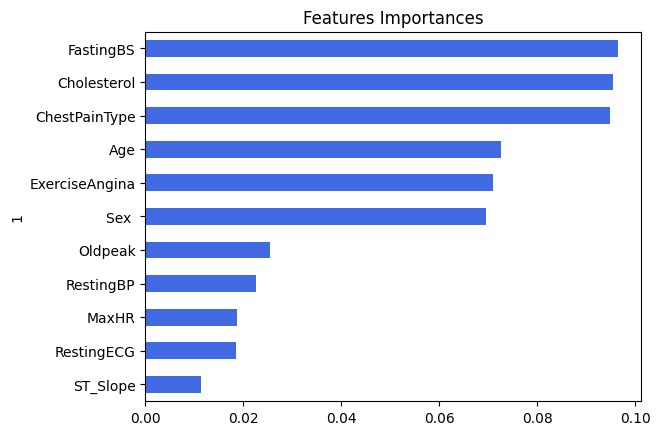

In [383]:
# Visualize the features by importance of the Random Forest model
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, feature_names), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='royalblue', title= 'Features Importances', legend=False)

In [384]:
# Random Forests in sklearn will automatically calculate feature importance
feature_names = ["Age", "RestingBP", "Cholesterol",	"FastingBS",	"MaxHR",	"Oldpeak",	"Sex_F",	"Sex_M",	"ChestPainType_ASY",	"ChestPainType_ATA",	"ChestPainType_NAP",	"ChestPainType_TA",	"RestingECG_LVH",	"RestingECG_Normal",	"RestingECG_ST",	"ExerciseAngina_N",	"ExerciseAngina_Y",	"ST_Slope_Down",	"ST_Slope_Flat",	"ST_Slope_Up"]
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, feature_names), reverse=True)

[(0.14252125904366397, 'ST_Slope_Up'),
 (0.11202170875282749, 'ST_Slope_Flat'),
 (0.09645866221529548, 'Oldpeak'),
 (0.09549843599532029, 'MaxHR'),
 (0.09482885327718159, 'Cholesterol'),
 (0.07255260036371354, 'Age'),
 (0.07098828794578574, 'ChestPainType_ASY'),
 (0.06957417539979052, 'RestingBP'),
 (0.05296669417205508, 'ExerciseAngina_Y'),
 (0.04608120225878824, 'ExerciseAngina_N'),
 (0.02538258148910927, 'ChestPainType_ATA'),
 (0.022498962323625183, 'FastingBS'),
 (0.0187854834452873, 'Sex_M'),
 (0.018423637756418133, 'Sex_F'),
 (0.01446298553218133, 'RestingECG_LVH'),
 (0.011905427827734717, 'RestingECG_Normal'),
 (0.011449018372373863, 'ChestPainType_NAP'),
 (0.008898157456699793, 'RestingECG_ST'),
 (0.007605392676185906, 'ChestPainType_TA'),
 (0.007096473695962675, 'ST_Slope_Down')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

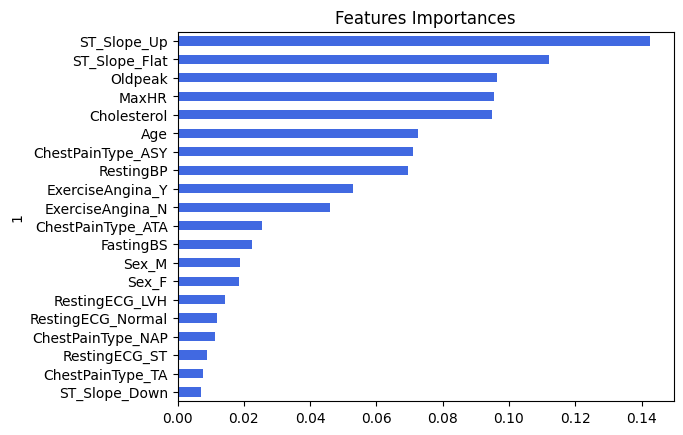

In [385]:
# Visualize the features by importance fort the Random Forest model
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, feature_names), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='royalblue', title= 'Features Importances', legend=False)

In [386]:
# Save the Random Forest model
filename = '/content/drive/My Drive/Models/random_forest_model.sav'
pickle.dump(rf_model, open(filename, 'wb'))

## Fitting the XGBoost model

In [387]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

In [388]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Convert y_train and y_test to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Initialize the model with some parameters - fine-tune for better performance:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

## Train the XGBoost model

In [389]:
# Train the XGBoost model
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:12:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Make Predictions using the XGBoost model

In [390]:
# Make predictions using XGBoost
y_pred = xgb_model.predict(X_test)

## Evaluation of the XGBoost model

In [391]:
# Evaluate the XGBoost model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        97
           1       0.91      0.93      0.92       133

    accuracy                           0.91       230
   macro avg       0.91      0.90      0.91       230
weighted avg       0.91      0.91      0.91       230



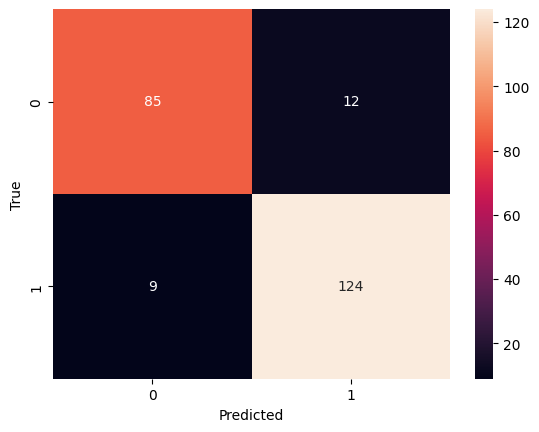

In [392]:
#Plot Confusion Matrix for XGBoost
plot_confusion_matrix(y_test, y_pred)

In [393]:
# Store overall metric (average) for the XGBoost model accuracy to compare models at the end
report = classification_report(y_test, y_pred, output_dict=True)

xgb_accuracy = report['accuracy']
xgb_macro_avg_f1 = report['macro avg']['f1-score']
xgb_weighted_avg_f1 = report['weighted avg']['f1-score']

print("\nOverall Accuracy: {:.2f}".format(xgb_accuracy))
print("Macro Avg F1-Score: {:.2f}".format(xgb_macro_avg_f1))
print("Weighted Avg F1-Score: {:.2f}".format(xgb_weighted_avg_f1))


Overall Accuracy: 0.91
Macro Avg F1-Score: 0.91
Weighted Avg F1-Score: 0.91


## XGBoost Feature Importance

In [394]:
# XGBoost in sklearn will automatically calculate feature importance
feature_names = ["Age", "Sex ", "ChestPainType", "RestingBP", "Cholesterol", "FastingBS", "RestingECG", "MaxHR", "ExerciseAngina", "Oldpeak", "ST_Slope"]
importances = xgb_model.feature_importances_
# We can sort the features by their importance
sorted(zip(xgb_model.feature_importances_, feature_names), reverse=True)

[(0.08800387, 'ExerciseAngina'),
 (0.0439321, 'MaxHR'),
 (0.036644205, 'FastingBS'),
 (0.034275975, 'RestingECG'),
 (0.031967707, 'ChestPainType'),
 (0.029158605, 'Oldpeak'),
 (0.028067358, 'RestingBP'),
 (0.02527375, 'Cholesterol'),
 (0.019336564, 'Sex '),
 (0.01755171, 'Age'),
 (0.01498502, 'ST_Slope')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

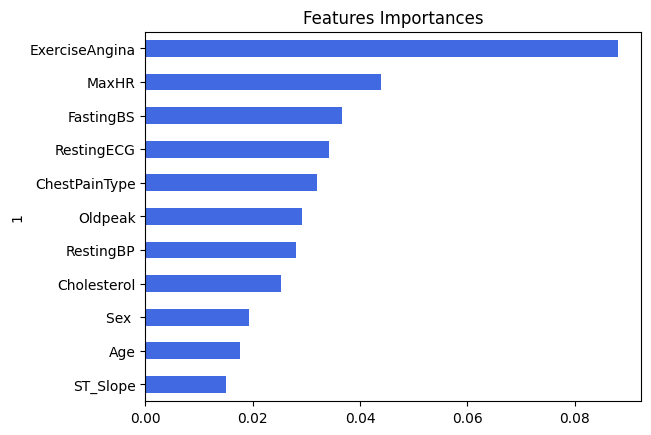

In [395]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(xgb_model.feature_importances_, feature_names), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='royalblue', title= 'Features Importances', legend=False)

In [396]:
# XGBoost in sklearn will automatically calculate feature importance
feature_names = ["Age", "RestingBP", "Cholesterol",	"FastingBS",	"MaxHR",	"Oldpeak",	"Sex_F",	"Sex_M",	"ChestPainType_ASY",	"ChestPainType_ATA",	"ChestPainType_NAP",	"ChestPainType_TA",	"RestingECG_LVH",	"RestingECG_Normal",	"RestingECG_ST",	"ExerciseAngina_N",	"ExerciseAngina_Y",	"ST_Slope_Down",	"ST_Slope_Flat",	"ST_Slope_Up"]
importances = xgb_model.feature_importances_
# We can sort the features by their importance
sorted(zip(xgb_model.feature_importances_, feature_names), reverse=True)

[(0.33176118, 'ST_Slope_Up'),
 (0.12008262, 'ST_Slope_Flat'),
 (0.08800387, 'ChestPainType_ASY'),
 (0.053351257, 'ExerciseAngina_N'),
 (0.0439321, 'Sex_M'),
 (0.039445575, 'ExerciseAngina_Y'),
 (0.036644205, 'Oldpeak'),
 (0.034275975, 'Sex_F'),
 (0.031967707, 'Cholesterol'),
 (0.02922695, 'ST_Slope_Down'),
 (0.029158605, 'ChestPainType_ATA'),
 (0.028067358, 'FastingBS'),
 (0.026844824, 'RestingECG_ST'),
 (0.02527375, 'MaxHR'),
 (0.020030925, 'RestingECG_LVH'),
 (0.019336564, 'RestingBP'),
 (0.01755171, 'Age'),
 (0.01498502, 'ChestPainType_NAP'),
 (0.005875709, 'ChestPainType_TA'),
 (0.004184202, 'RestingECG_Normal')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

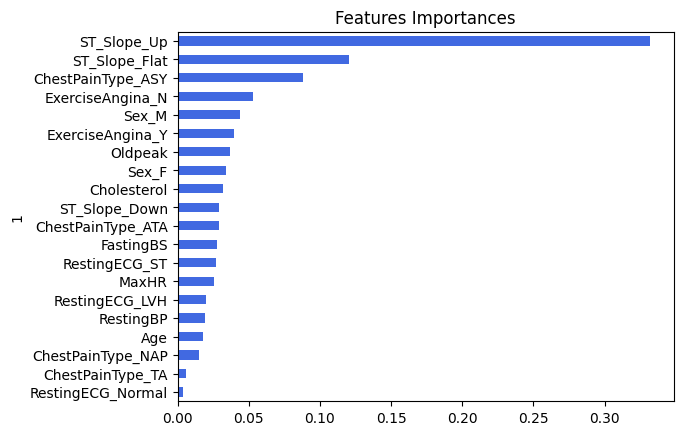

In [397]:
# Visualize the features by importance for XGBoost
importances_df = pd.DataFrame(sorted(zip(xgb_model.feature_importances_, feature_names), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='royalblue', title= 'Features Importances', legend=False)

In [398]:
# Save the XGBoost model
filename = '/content/drive/My Drive/Models/xgboost_model.sav'
pickle.dump(xgb_model, open(filename, 'wb'))

## Neural Networks

In [399]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[1])
hidden_nodes_layer1 = 128
hidden_nodes_layer2 = 96
hidden_nodes_layer3 = 64
hidden_nodes_layer4 = 32
hidden_nodes_layer5 = 16

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation='sigmoid'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation='sigmoid'))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation='sigmoid'))

# Fourth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation='sigmoid'))

# Fifth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer5, activation='sigmoid'))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Check the structure of the model
nn.summary()
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 128)                 │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 96)                  │          12,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,905 (93.38 KB)

 Trainable params: 23,905 (93.38 KB)

 Non-trainable params: 0 (0.00 B)

In [400]:
# Compile the Neural Network model
nn.compile(loss = 'huber', optimizer = 'adam', metrics = ['accuracy'])

## Train the Neural Network model

In [401]:
# Ensure y_train is numeric
y_train = y_train.astype(float) # If y_train contains strings, converts it to float

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, validation_split= 0.15, epochs= 100, batch_size=50)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.4763 - loss: 0.1607 - val_accuracy: 0.4904 - val_loss: 0.1484
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5515 - loss: 0.1321 - val_accuracy: 0.4904 - val_loss: 0.1237
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5977 - loss: 0.1222 - val_accuracy: 0.4904 - val_loss: 0.1216
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5519 - loss: 0.1199 - val_accuracy: 0.4904 - val_loss: 0.1229
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6001 - loss: 0.1133 - val_accuracy: 0.7019 - val_loss: 0.1146
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7862 - loss: 0.1117 - val_accuracy: 0.8077 - val_loss: 0.1044
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7711 - loss: 0.1011 - val_accuracy: 0.8269 - val_loss: 0.0882
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8551 - loss: 0.0822 - val_accuracy: 0.8

## Evaluation of the Neural Network model

In [402]:
# Ensure y_test is numeric
y_test = y_test.astype(float)  # If y_test contains strings, converts it to float

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - 6ms/step - accuracy: 0.8957 - loss: 0.0443
Loss: 0.04433809220790863, Accuracy: 0.895652174949646


<Axes: >

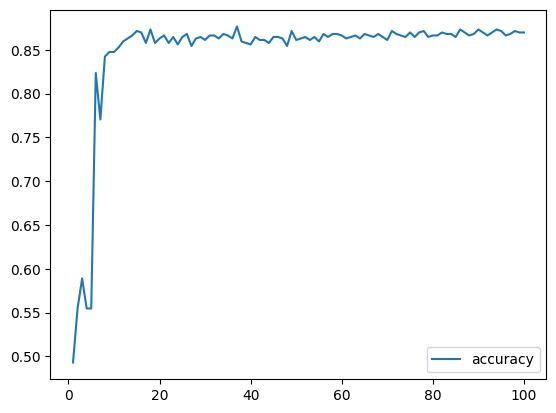

In [403]:
p_df = pd.DataFrame(fit_model.history, index = range(1, len(fit_model.history['loss'])+1))
p_df.plot(y = 'accuracy')

Neural networks model has a highest accuracy of the machine-learning models to predict a healthy and diseased heart.

In [404]:
# Save the Neural Network model
filename = '/content/drive/My Drive/Models/nn.sav'
pickle.dump(nn, open(filename, 'wb'))

In [405]:
#Used to Test the loaded model only and compare with Streamlit app

loaded_model = pickle.load(open(filename, 'rb'))

input_data = pd.DataFrame([[38, 110, 289, 0, 105, 1.5, False, True, True, False, False,
                                False, False, True, False, False, True, True,
                                False, False]],
                              columns=['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY',
                                       'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST',
                                       'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up'])

prediction = loaded_model.predict(input_data)

# Convert prediction to an integer safely
prediction_value = prediction[0].item()

print(prediction_value)

if prediction_value == 0:
    print("The patient does not have a heart disease.")
else:
    print("The patient has a heart disease.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
-5.4360367357730865e-05
The patient has a heart disease.


# **Models Comparison Bar Chart:**
Comparing multiple models using a bar chart to show the accuracy

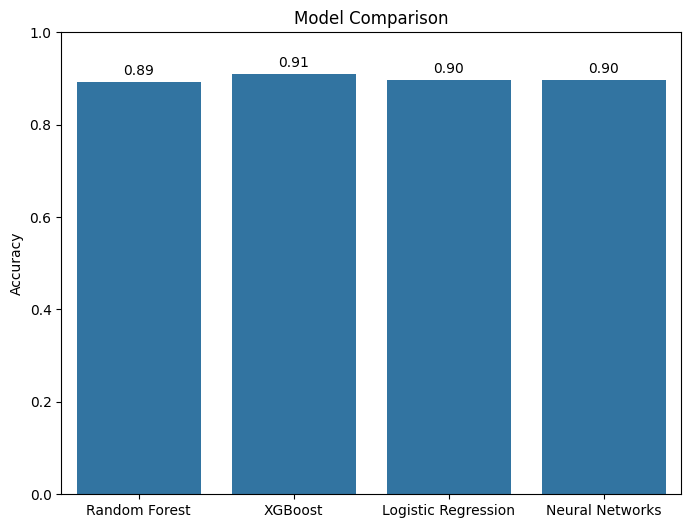

In [406]:
model_names = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Neural Networks']
accuracies = [rf_accuracy, xgb_accuracy, lrm_accuracy, model_accuracy]

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=model_names, y=accuracies)
plt.title("Model Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

# Adding the values on top of each bar
for i, v in enumerate(accuracies):
    ax.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

plt.show()

## Increasing accuracy by dropping some features from the logistics regression model

In [407]:
p_df = df.toPandas()
p_df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0,Up,0


In [408]:
# Drop the ID columns, 'ST_Slope', "RestingECG" and 'MaxHR'.
important_df = p_df.drop(["ST_Slope","RestingECG", "MaxHR"], axis=1)


In [409]:
# Convert categorical data to numeric with `pd.get_dummies`
numeric_p_df = pd.get_dummies(important_df, columns=['Sex', 'ChestPainType','ExerciseAngina'])
numeric_p_df

,Age,RestingBP,Cholesterol,FastingBS,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ExerciseAngina_N,ExerciseAngina_Y
0,40,140,289,0,0,0,False,True,False,True,False,False,True,False
1,49,160,180,0,1,1,True,False,False,False,True,False,True,False
2,37,130,283,0,0,0,False,True,False,True,False,False,True,False
3,48,138,214,0,1.5,1,True,False,True,False,False,False,False,True
4,54,150,195,0,0,0,False,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,1.2,1,False,True,False,False,False,True,True,False
914,68,144,193,1,3.4,1,False,True,True,False,False,False,True,False
915,57,130,131,0,1.2,1,False,True,True,False,False,False,False,True
916,57,130,236,0,0,1,True,False,False,True,False,False,True,False


In [410]:
# Split our preprocessed data into our features and target arrays
target = numeric_p_df['HeartDisease']
features = numeric_p_df.drop(columns=['HeartDisease'])
X = features.values  # Features array
y = target.values    # Target array
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)

number_input_features = X_train.shape[1]
print(f"Number of input features: {number_input_features}")

Number of input features: 13


In [411]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [412]:
# Import the new LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
classifier = LogisticRegression(solver='liblinear', random_state=1, max_iter=200)
classifier

# Fit the model using training data
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=1, solver='liblinear')

In [413]:
# Make a prediction using the new logistic regression model and the testing data
predictions = classifier.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test})

,Prediction,Actual
0,1,1
1,0,0
2,1,1
3,1,1
4,0,0
...,...,...
225,1,1
226,1,1
227,1,0
228,1,1


In [414]:
# Generate a confusion matrix for the new logistic regression model
from sklearn.metrics import confusion_matrix

print("Confusion Matrix")
confusion_matrix(y_test, predictions)

Confusion Matrix


array([[ 80,  17],
       [ 16, 117]])

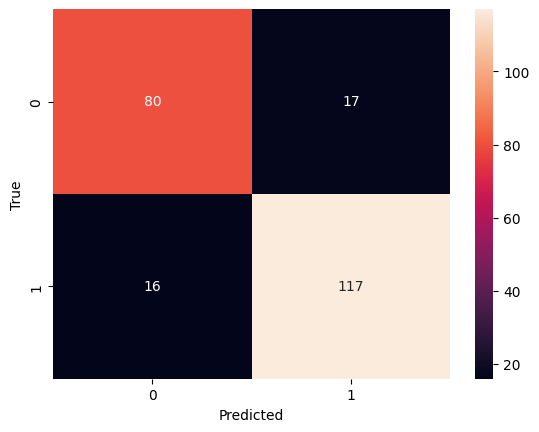

In [415]:
#Plot Confusion Matrix for the new logistic regression model
plot_confusion_matrix(y_test, predictions)

In [416]:
# Print the classification report for the new logistic regression model
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83        97
           1       0.87      0.88      0.88       133

    accuracy                           0.86       230
   macro avg       0.85      0.85      0.85       230
weighted avg       0.86      0.86      0.86       230



In [417]:
# Store overall metric (average) for accuracy to compare models at the end
report = classification_report(y_test, predictions, output_dict=True)

lrm_dropf_accuracy = report['accuracy']
lrm_dropf_macro_avg_f1 = report['macro avg']['f1-score']
lrm_dropf_weighted_avg_f1 = report['weighted avg']['f1-score']

print("\nOverall Accuracy: {:.2f}".format(lrm_dropf_accuracy))
print("Macro Avg F1-Score: {:.2f}".format(lrm_dropf_macro_avg_f1))
print("Weighted Avg F1-Score: {:.2f}".format(lrm_dropf_weighted_avg_f1))


Overall Accuracy: 0.86
Macro Avg F1-Score: 0.85
Weighted Avg F1-Score: 0.86


### **Final Model Evaluation**
## Evaluate all models including Logistic Regression after dropping features


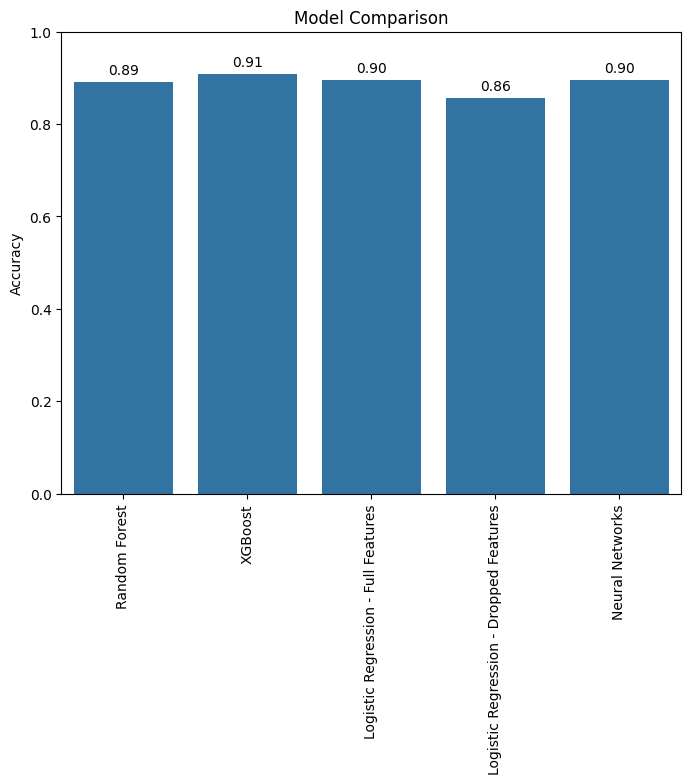

In [418]:
model_names = ['Random Forest', 'XGBoost', 'Logistic Regression - Full Features', 'Logistic Regression - Dropped Features', 'Neural Networks']
accuracies = [rf_accuracy, xgb_accuracy, lrm_accuracy, lrm_dropf_accuracy, model_accuracy]

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=model_names, y=accuracies)
plt.title("Model Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

# Rotate x-axis labels to be vertical
plt.xticks(rotation=90)

# Adding the values on top of each bar
for i, v in enumerate(accuracies):
    ax.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

plt.show()